In [1]:
import numpy as np
import gym
import gym_minigrid
import sys
import matplotlib.pyplot as plt
import tensorflow as tf

from gym_minigrid.wrappers import *
sys.path.append('..')
from envs import *
from utils import *
from general import *
from types import SimpleNamespace
from stable_baselines import *
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines.common.policies import MlpPolicy, CnnPolicy, FeedForwardPolicy
from stable_baselines import PPO2
from stable_baselines.common.vec_env import SubprocVecEnv
from stable_baselines.a2c.utils import conv, linear, conv_to_fc, batch_to_seq, seq_to_batch, lstm



In [2]:
def custom_cnn(scaled_images, **kwargs):
    activ = tf.nn.relu
    layer_1 = activ(conv(scaled_images, 'c1', n_filters=16, filter_size=2, stride=1, init_scale=np.sqrt(2), **kwargs))
    layer_2 = activ(conv(layer_1, 'c2', n_filters=16, filter_size=2, stride=1, init_scale=np.sqrt(2), **kwargs))
    layer_3 = activ(conv(layer_2, 'c3', n_filters=16, filter_size=2, stride=1, init_scale=np.sqrt(2), **kwargs))
    layer_3 = conv_to_fc(layer_3)
    return activ(linear(layer_3, 'fc1', n_hidden=32, init_scale=np.sqrt(2)))

class CustomCnnPolicy(FeedForwardPolicy):
    
    def __init__(self, sess, ob_space, ac_space, n_env, n_steps, n_batch, reuse=False, **_kwargs):
        super(CustomCnnPolicy, self).__init__(sess, ob_space, ac_space, n_env, n_steps, n_batch, reuse,
                                        cnn_extractor=custom_cnn,
                                        feature_extraction="cnn", **_kwargs)
        
def make_env(seeds, rank=0):
    env_name = 'MiniGrid-BallFindingTrain-v0'
    env = gym.make(env_name)
    env = FullyObsWrapper(env)
    env = MiniGridTimeLimitWrapper(env, 4000)
#     env = MiniGridRescaleObservationWrapper(env)
    env = ReseedWrapper(env, seeds, rank % len(seeds))
    env = PredicateWrapper(env, [])
    return env

def execute_plan(env, actions):
    info = []
    env.reset()
    for a in actions:
        obs, rew, done, inf = env.step(a)
        info.append((rew, done))
        im = env.render(mode='rgb_array')
        plt.imshow(im)
        plt.show()
    print (info)

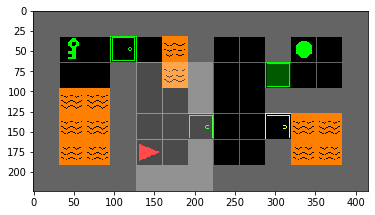

In [3]:
seeds = range(64)

env = make_env(seeds)
env = DummyVecEnv([lambda: env])

for i in range(1):
    env.reset()
    im = env.render(mode='rgb_array')
    plt.imshow(im)
    plt.show()



In [4]:
model = PPO2(MlpPolicy, env, verbose=1)

n_million_steps = 20
step = 3
model = PPO2.load(f'ppo2_{n_million_steps}_{step}_key.model')

W0920 07:22:18.365560 4761384384 deprecation_wrapper.py:119] From /Users/karan.goel/anaconda3/envs/rlexp/lib/python3.6/site-packages/stable_baselines/common/tf_util.py:98: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0920 07:22:18.367871 4761384384 deprecation_wrapper.py:119] From /Users/karan.goel/anaconda3/envs/rlexp/lib/python3.6/site-packages/stable_baselines/common/tf_util.py:107: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0920 07:22:18.370288 4761384384 deprecation_wrapper.py:119] From /Users/karan.goel/anaconda3/envs/rlexp/lib/python3.6/site-packages/stable_baselines/common/policies.py:115: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0920 07:22:18.372882 4761384384 deprecation_wrapper.py:119] From /Users/karan.goel/anaconda3/envs/rlexp/lib/python3.6/site-packages/stable_baselines/common/input.py:25: The name tf.placeholder is deprecated. Please use tf.compa

Loading a model without an environment, this model cannot be trained until it has a valid environment.


In [5]:
# Enjoy trained agent
obs = env.reset()
tot_ret = 0
tot_steps = 0
while True:
    action, _states = model.predict(obs)
    obs, reward, done, info = env.step(action)
    tot_ret += reward
    tot_steps += 1
    if done:
        print (tot_ret, tot_steps)
        tot_ret = 0.
        tot_steps = 0
        obs = env.reset()
    env.render()

Success Key
Success Left door 1
Lava
[2.] 42
Success Key
Success Left door 1
Lava
[2.] 41
Success Key
Success Left door 1
Lava
[2.] 165
Success Key
Success Left door 1
Lava
[2.] 25
Success Key
Success Left door 1
Lava
[2.] 330
Success Key
Success Left door 1
Success Left door 2
Success locked
[5.] 1453
Success Key
Success Left door 1
Lava
[2.] 259
Success Key
Success Left door 1
Drop
Lava
[1.9] 1646
Success Key
Success Left door 1
Lava
[2.] 134
Success Key
Success Left door 1
Drop
Success Left door 2
Drop
Success locked
[4.8] 438
Success Key
Success Left door 1
Lava
[2.] 79
Success Key
Success Left door 1
Success Left door 2
Drop
Success locked
[4.9] 490
Success Key
Success Left door 1
Lava
[2.] 111
Success Key
Success Left door 1
Lava
[2.] 309
Success Key
Success Left door 1
Lava
[2.] 109
Success Key
Success Left door 1
Lava
[2.] 247
Success Key
Lava
[1.] 206
Success Key
Success Left door 1
Lava
[2.] 93
Success Key
Success Left door 1
Lava
[2.] 589
Success Key
Success Left door 1
Succ

KeyboardInterrupt: 

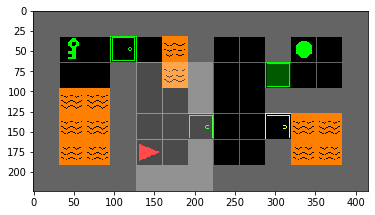

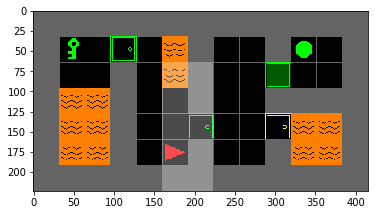

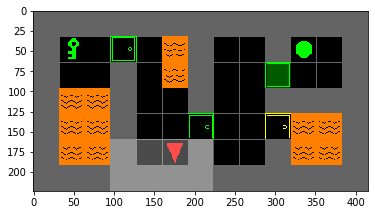

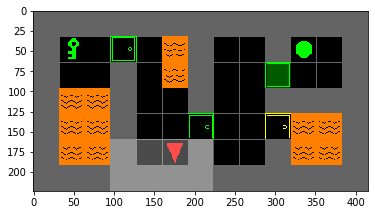

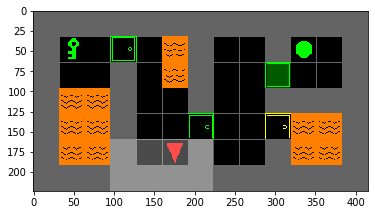

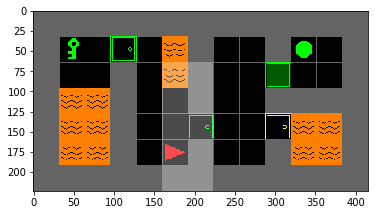

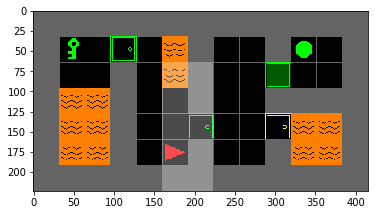

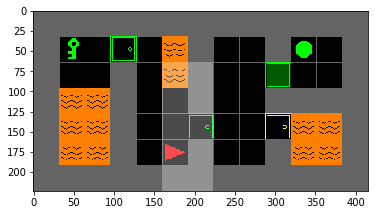

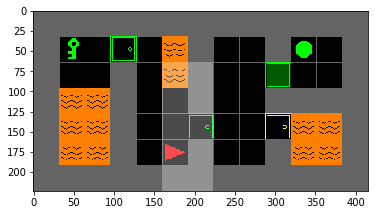

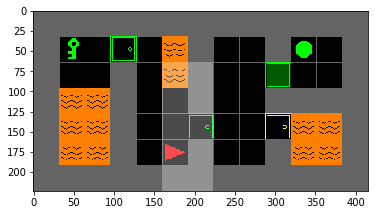

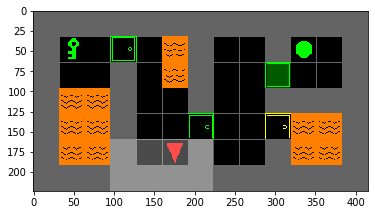

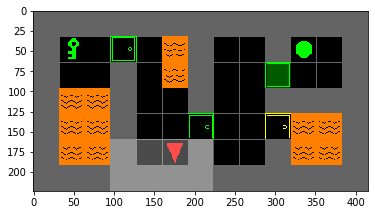

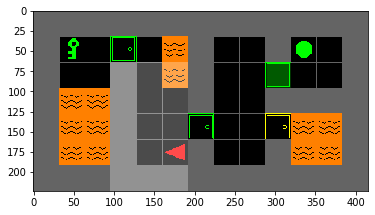

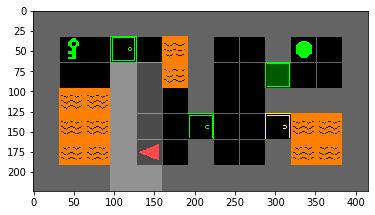

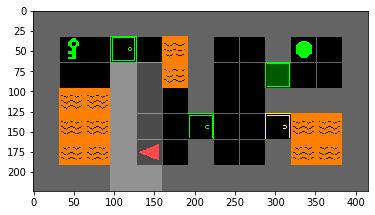

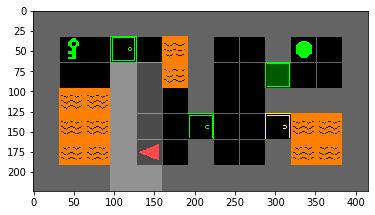

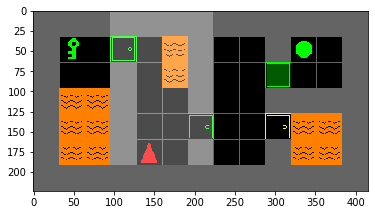

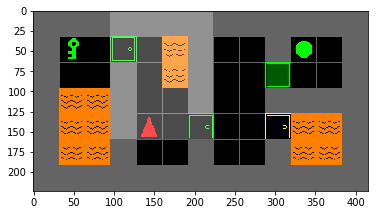

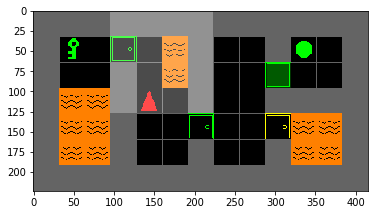

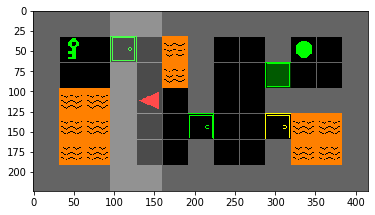

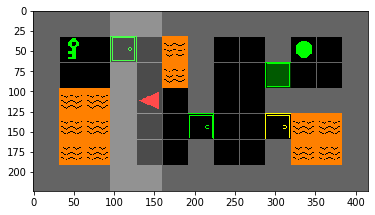

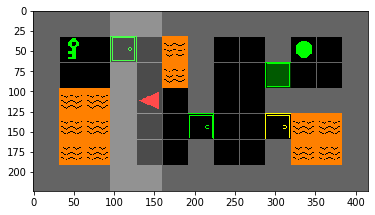

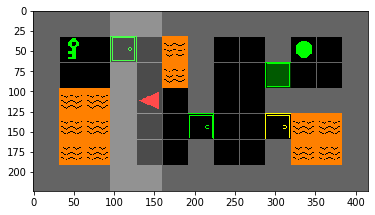

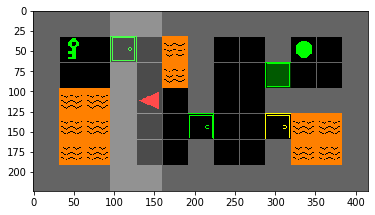

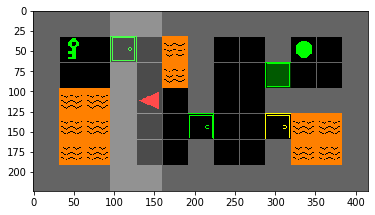

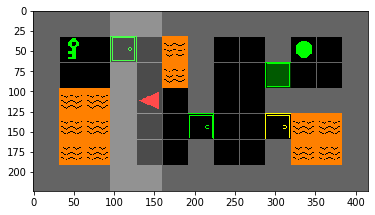

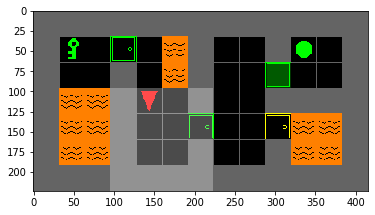

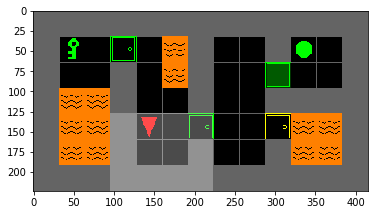

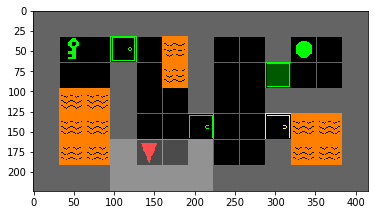

In [ ]:
env = make_env(seeds)
execute_plan(env, [6, 2, 1, 2, 2, 0, 5, 2, 2, 2, 1, 3, 1, 2, 2, 2, 1, 2, 2, 0, 2, 2, 5, 2, 2, 2, 0, 2, 2, 2, 1, 5, 2, 0, 0, 4, 1, 1, 3])

In [5]:
print (dir(model))
print (dir(model.policy))

['__abstractmethods__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_abc_cache', '_abc_negative_cache', '_abc_negative_cache_version', '_abc_registry', '_get_pretrain_placeholders', '_init_num_timesteps', '_is_vectorized_observation', '_load_from_file', '_param_load_ops', '_requires_vec_env', '_save_to_file', '_setup_learn', '_setup_load_operations', '_softmax', '_train', '_train_step', '_vectorize_action', 'act_model', 'action_ph', 'action_probability', 'action_space', 'advs_ph', 'approxkl', 'clip_range_ph', 'clip_range_vf_ph', 'clipfrac', 'cliprange', 'cliprange_vf', 'ent_coef', 'entropy', 'env', 'episode_reward', 'full_tensorboard_log', 'gamma', 'get_env', 'get_parameter_list', 'get_para